-this needs to be checked because there is apparenlty no change in sea ice
-also need to stop saving figures because they are being overwritten when i copy and paste code from previous scripts

In [51]:
from cf_xarray.datasets import ds_with_tuple
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
pwd

'/Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy'

In [53]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import griddata
import xeofs as xe
from geometry_izzyv1 import grad_sphere
from regression_izzyv1 import linregress_3D
import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
import warnings
import os
warnings.filterwarnings('ignore')



In [54]:
# constant
rho_a = 1.225 # air density kg m-3

Cd = 1.5e-3 # drag coeff

In [55]:
gridtype = 'remapcon'

In [56]:
# dot dataset
path = '/Users/iw2g24/PycharmProjects/SSH_project/'
print(path)
ds = xr.open_dataset(path + 'Data/dot_all_30bmedian_goco05c_sig3_1.nc')
print(ds)
# ERA5 remap dataset
ds_era5 = xr.open_dataset(path + 'Data/ERA5_u10v10_Antartica_2000-2023_' + gridtype + '.nc')

/Users/iw2g24/PycharmProjects/SSH_project/
<xarray.Dataset> Size: 109MB
Dimensions:          (longitude: 360, latitude: 64, time: 196, edge_lat: 65,
                      edge_lon: 361)
Coordinates:
  * longitude        (longitude) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * latitude         (latitude) float64 512B -81.75 -81.25 ... -50.75 -50.25
  * time             (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * edge_lat         (edge_lat) float64 520B -82.0 -81.5 -81.0 ... -50.5 -50.0
  * edge_lon         (edge_lon) float64 3kB -180.0 -179.0 -178.0 ... 179.0 180.0
Data variables:
    dot              (longitude, latitude, time) float64 36MB ...
    ug               (longitude, latitude, time) float64 36MB ...
    vg               (longitude, latitude, time) float64 36MB ...
    land_mask        (longitude, latitude) float64 184kB ...
    intersat_offset  float64 8B ...
Attributes:
    history:      Created 08/01/2022, 00:5223
    description:  ENVISAT + CryoSat2 altimetry 

<xarray.Dataset> Size: 10MB
Dimensions:                         (time: 1, nv: 2, xc: 432, yc: 432)
Coordinates:
  * time                            (time) datetime64[ns] 8B 2022-08-04T12:00:00
  * xc                              (xc) float64 3kB -5.388e+03 ... 5.388e+03
  * yc                              (yc) float64 3kB 5.388e+03 ... -5.388e+03
    lat                             (yc, xc) float32 746kB ...
    lon                             (yc, xc) float32 746kB ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid          int32 4B ...
    time_bnds                       (time, nv) datetime64[ns] 16B ...
    ice_conc                        (time, yc, xc) float64 1MB ...
    raw_ice_conc_values             (time, yc, xc) float64 1MB ...
    total_standard_uncertainty      (time, yc, xc) float64 1MB ...
    smearing_standard_uncertainty   (time, yc, xc) float64 1MB ...
    algorithm_standard_uncertainty  (time, yc, xc) float64 1MB ...
    status_flag     

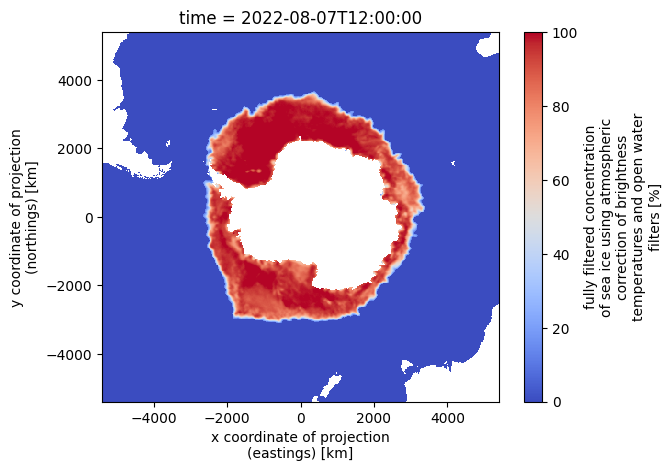

(432,)
(432,)


In [57]:
#sea ice drift data from nsidc
directory = "/Users/iw2g24/PycharmProjects/SSH_project/mca_shared_izzy/si_conc_eumetsat/"
ds_example = xr.open_dataset(directory + 'ice_conc_sh_ease2-250_icdr-v3p0_202208041200.nc')
print(ds_example)
print(ds_example['xc'])

ds_example2 = xr.open_dataset(directory + 'ice_conc_sh_ease2-250_icdr-v3p0_202208071200.nc')
print(ds_example2)
print(ds_example2['xc'])

variable_name = "ice_conc"

# Extract the data array for plotting
data_to_plot = ds_example2[variable_name]
print("plotted data size",data_to_plot.shape)

# Plot using xarray's built-in method
data_to_plot.plot(cmap="coolwarm")  # Replace 'viridis' with your preferred color map
#plt.title(f"{variable_name} at time {ds_example['time']}")
plt.show()

print(ds_example2["xc"].shape)
print(ds_example2["yc"].shape)

In [58]:
print(ds_example2["ice_conc"].attrs)

{'long_name': 'fully filtered concentration of sea ice using atmospheric correction of brightness temperatures and open water filters', 'standard_name': 'sea_ice_area_fraction', 'units': '%', 'valid_min': 0, 'valid_max': 10000, 'grid_mapping': 'Lambert_Azimuthal_Grid', 'comment': 'this field is the primary sea ice concentration estimate for this climate data record', 'ancillary_variables': 'total_standard_uncertainty status_flag'}


In [59]:
print(ds_example2.variables)


Frozen({'Lambert_Azimuthal_Grid': <xarray.Variable ()> Size: 4B
[1 values with dtype=int32]
Attributes:
    grid_mapping_name:               lambert_azimuthal_equal_area
    longitude_of_projection_origin:  0.0
    latitude_of_projection_origin:   -90.0
    false_easting:                   0.0
    false_northing:                  0.0
    semi_major_axis:                 6378137.0
    inverse_flattening:              298.257223563
    proj4_string:                    +proj=laea +lon_0=0 +datum=WGS84 +ellps=..., 'time': <xarray.IndexVariable 'time' (time: 1)> Size: 8B
array(['2022-08-07T12:00:00.000000000'], dtype='datetime64[ns]')
Attributes:
    long_name:      reference time of product
    standard_name:  time
    axis:           T
    bounds:         time_bnds, 'time_bnds': <xarray.Variable (time: 1, nv: 2)> Size: 16B
[2 values with dtype=datetime64[ns]], 'xc': <xarray.IndexVariable 'xc' (xc: 432)> Size: 3kB
array([-5387.5, -5362.5, -5337.5, ...,  5337.5,  5362.5,  5387.5])
Attribute

In [60]:
ds_check = xr.open_dataset('si_conc_sh_eumetsat.nc')
print(ds_check)

<xarray.Dataset> Size: 26GB
Dimensions:                   (time: 3149, nv: 2, yc: 432, xc: 432)
Coordinates:
  * time                      (time) datetime64[ns] 25kB 2002-07-03T12:00:00 ...
  * xc                        (xc) float64 3kB -5.388e+03 ... 5.388e+03
  * yc                        (yc) float64 3kB 5.388e+03 ... -5.388e+03
    lat                       (yc, xc) float32 746kB ...
    lon                       (yc, xc) float32 746kB ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid    (time) int32 13kB ...
    time_bnds                 (time, nv) datetime64[ns] 50kB ...
    ice_conc                  (time, yc, xc) float64 5GB ...
    raw_ice_conc_values       (time, yc, xc) float64 5GB ...
    total_standard_error      (time, yc, xc) float64 5GB ...
    smearing_standard_error   (time, yc, xc) float64 5GB ...
    algorithm_standard_error  (time, yc, xc) float64 5GB ...
    status_flag               (time, yc, xc) float32 2GB ...
Attributes: (12/40

In [61]:
ds_eumetsat_conc = xr.open_dataset('si_conc_sh_eumetsat.nc')
print(ds_eumetsat_conc)

<xarray.Dataset> Size: 26GB
Dimensions:                   (time: 3149, nv: 2, yc: 432, xc: 432)
Coordinates:
  * time                      (time) datetime64[ns] 25kB 2002-07-03T12:00:00 ...
  * xc                        (xc) float64 3kB -5.388e+03 ... 5.388e+03
  * yc                        (yc) float64 3kB 5.388e+03 ... -5.388e+03
    lat                       (yc, xc) float32 746kB ...
    lon                       (yc, xc) float32 746kB ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid    (time) int32 13kB ...
    time_bnds                 (time, nv) datetime64[ns] 50kB ...
    ice_conc                  (time, yc, xc) float64 5GB ...
    raw_ice_conc_values       (time, yc, xc) float64 5GB ...
    total_standard_error      (time, yc, xc) float64 5GB ...
    smearing_standard_error   (time, yc, xc) float64 5GB ...
    algorithm_standard_error  (time, yc, xc) float64 5GB ...
    status_flag               (time, yc, xc) float32 2GB ...
Attributes: (12/40

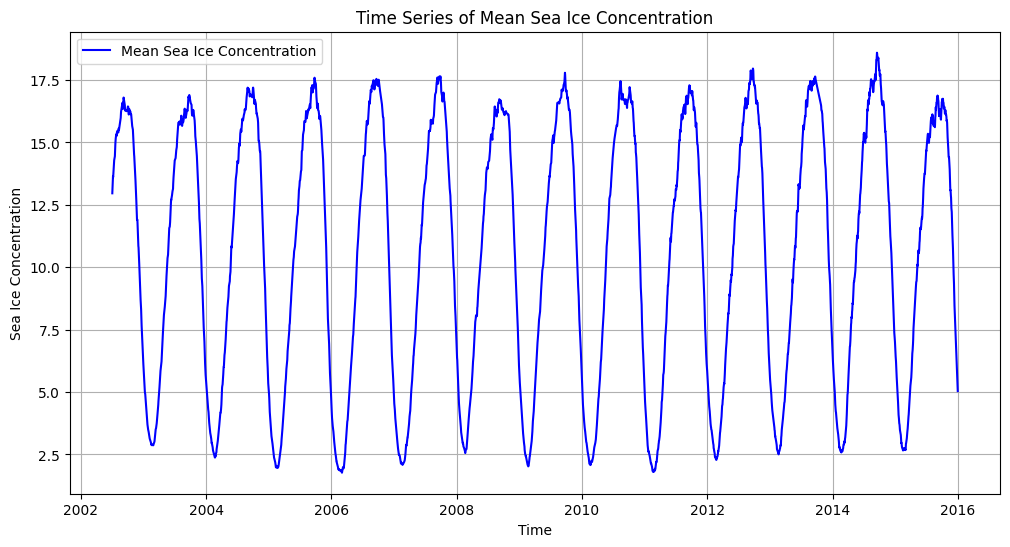

In [62]:
import matplotlib.pyplot as plt
import xarray as xr

# Open the dataset
ds_eumetsat_conc = xr.open_dataset('si_conc_sh_eumetsat.nc')

# Compute mean sea ice concentration over the grid for each time step
mean_seaice_conc = ds_eumetsat_conc['ice_conc'].mean(dim=('yc', 'xc'))

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(ds_eumetsat_conc['time'], mean_seaice_conc, label="Mean Sea Ice Concentration", color='b')
plt.xlabel('Time')
plt.ylabel('Sea Ice Concentration')
plt.title('Time Series of Mean Sea Ice Concentration')
plt.legend()
plt.grid()
plt.show()


In [63]:
data_to_plot = ds_eumetsat_conc["ice_conc"]
print("xgrid shape:", ds_eumetsat_conc["xc"].shape)
print("ygrid shape:", ds_eumetsat_conc["yc"].shape)
print("Data to plot shape:", data_to_plot.isel(time = 0).shape)


xgrid shape: (432,)
ygrid shape: (432,)
Data to plot shape: (432, 432)


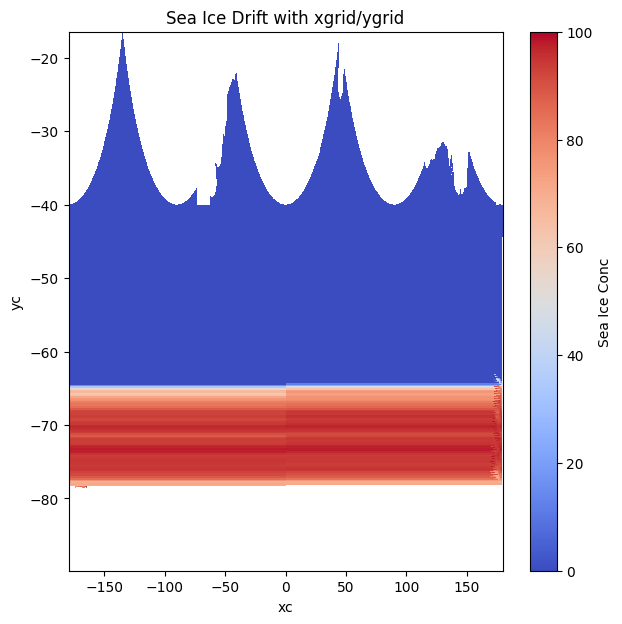

In [64]:
# Plot sea ice conc using lat and lon coordinates
data_to_plot = ds_eumetsat_conc["ice_conc"]

plt.figure(figsize=(7,7))
plt.pcolormesh(
    ds_eumetsat_conc["lon"],
    ds_eumetsat_conc["lat"],
    data_to_plot.isel(time=0),
    cmap="coolwarm",
    shading="auto"
)
plt.colorbar(label="Sea Ice Conc")
plt.title("Sea Ice Drift with xgrid/ygrid")
plt.xlabel("xc")
plt.ylabel("yc")
plt.show()


In [65]:
print("Data shape:", ds_eumetsat_conc["ice_conc"].shape)
print("Longitude shape:", ds_eumetsat_conc["lon"].shape)
print("Latitude shape:", ds_eumetsat_conc["lat"].shape)
print('ice conc max:', ds_eumetsat_conc["ice_conc"].max())


Data shape: (3149, 432, 432)
Longitude shape: (432, 432)
Latitude shape: (432, 432)
ice conc max: <xarray.DataArray 'ice_conc' ()> Size: 8B
array(100.)
Attributes:
    long_name:            fully filtered concentration of sea ice using atmos...
    standard_name:        sea_ice_area_fraction
    units:                %
    valid_min:            0
    valid_max:            10000
    grid_mapping:         Lambert_Azimuthal_Grid
    ancillary_variables:  total_standard_error status_flag
    comment:              this field is the primary sea ice concentration est...


In [66]:
print(ds_eumetsat_conc["lon"])

<xarray.DataArray 'lon' (yc: 432, xc: 432)> Size: 746kB
array([[ -45.      ,  -44.866753,  -44.732887, ...,   44.732887,   44.866753,
          45.      ],
       [ -45.133247,  -45.      ,  -44.86613 , ...,   44.86613 ,   45.      ,
          45.133247],
       [ -45.267113,  -45.13387 ,  -45.      , ...,   45.      ,   45.13387 ,
          45.267113],
       ...,
       [-134.7329  , -134.86613 , -135.      , ...,  135.      ,  134.86613 ,
         134.7329  ],
       [-134.86676 , -135.      , -135.13387 , ...,  135.13387 ,  135.      ,
         134.86676 ],
       [-135.      , -135.13324 , -135.2671  , ...,  135.2671  ,  135.13324 ,
         135.      ]], dtype=float32)
Coordinates:
  * xc       (xc) float64 3kB -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc       (yc) float64 3kB 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
    lat      (yc, xc) float32 746kB -16.62 -16.82 -17.02 ... -16.82 -16.62
    lon      (yc, xc) float32 746kB -45.0 -44.87 -44.73 ... 135.3 135.1 135.

In [67]:
print(ds_eumetsat_conc.values)
print(ds_eumetsat_conc['lon'].shape)
print(ds_eumetsat_conc['lat'].shape)

<bound method Mapping.values of <xarray.Dataset> Size: 26GB
Dimensions:                   (time: 3149, nv: 2, yc: 432, xc: 432)
Coordinates:
  * time                      (time) datetime64[ns] 25kB 2002-07-03T12:00:00 ...
  * xc                        (xc) float64 3kB -5.388e+03 ... 5.388e+03
  * yc                        (yc) float64 3kB 5.388e+03 ... -5.388e+03
    lat                       (yc, xc) float32 746kB -16.62 -16.82 ... -16.62
    lon                       (yc, xc) float32 746kB -45.0 -44.87 ... 135.0
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid    (time) int32 13kB ...
    time_bnds                 (time, nv) datetime64[ns] 50kB ...
    ice_conc                  (time, yc, xc) float64 5GB nan nan nan ... nan nan
    raw_ice_conc_values       (time, yc, xc) float64 5GB ...
    total_standard_error      (time, yc, xc) float64 5GB ...
    smearing_standard_error   (time, yc, xc) float64 5GB ...
    algorithm_standard_error  (time, yc, xc) flo

In [68]:
print(ds_eumetsat_conc['time'].dtype)

datetime64[ns]


In [69]:
time_eumetsat = ds_eumetsat_conc['time'].values
print("eumetsat conc time", time_eumetsat[284],time_eumetsat[479])

eumetsat conc time 2004-04-23T12:00:00.000000000 2005-08-09T12:00:00.000000000


In [70]:
#reorder ds_nsidc_conc  to have time_new, lat, lon

# Step 1: Extract lat, lon, and sea ice concentration
lat_eumetsat = ds_eumetsat_conc['lat'].values  # Shape (y, x)
lon_eumetsat = ds_eumetsat_conc['lon'].values  # Shape (y, x)
time_new = ds_eumetsat_conc['time'].values  # Shape (time_new)

# Step 2: Flatten the lat and lon arrays into 1D arrays
lat_flat = lat_eumetsat.flatten()
lon_flat = lon_eumetsat.flatten()

# Step 3: Reshape the variable (e.g., 'sea_ice_conc') to match the flattened grid
var = ds_check['ice_conc'].values  # Shape (time_new, tdim, y, x)

# Remove 'tdim' dimension by squeezing it
var_squeezed = var[:, :, :]  # Shape becomes (time_new, y, x)

# Flatten 'y' and 'x' into a single dimension
var_flat = var_squeezed.reshape((var_squeezed.shape[0], -1))  # Shape (time_new, y*x)

# Step 4: Create a new dataset with dimensions (time_new, lat, lon)
ds_reordered = xr.Dataset(
    data_vars={
        'si_conc': (['time_new', 'points'], var_flat)  # Data flattened
    },
    coords={
        'time_new': time_new,      # Time dimension
        'lat': ('points', lat_flat),  # 1D lat coordinate
        'lon': ('points', lon_flat)   # 1D lon coordinate
    }
)

# Step 5: Verify the new dataset
print(ds_reordered)

# Step 6: Save the new dataset
output_file = "reordered_sea_ice_concentration_eumetsat2.nc"
ds_reordered.to_netcdf(output_file)
print(f"Reordered dataset saved to: {output_file}")


<xarray.Dataset> Size: 5GB
Dimensions:   (time_new: 3149, points: 186624)
Coordinates:
  * time_new  (time_new) datetime64[ns] 25kB 2002-07-03T12:00:00 ... 2015-12-...
    lat       (points) float32 746kB -16.62 -16.82 -17.02 ... -16.82 -16.62
    lon       (points) float32 746kB -45.0 -44.87 -44.73 ... 135.3 135.1 135.0
Dimensions without coordinates: points
Data variables:
    si_conc   (time_new, points) float64 5GB nan nan nan nan ... nan nan nan nan
Reordered dataset saved to: reordered_sea_ice_concentration_eumetsat2.nc


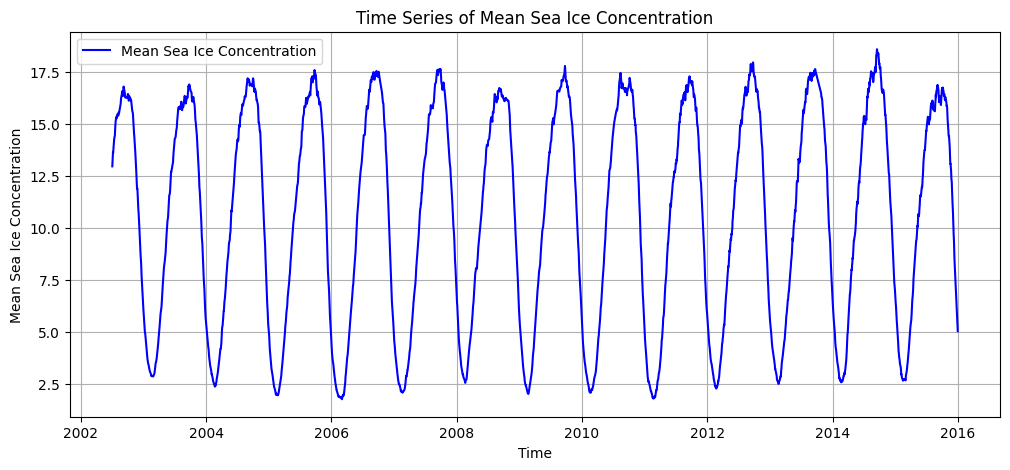

In [71]:
import matplotlib.pyplot as plt

# Compute mean sea ice concentration over all grid points for each time step
mean_si_conc = ds_reordered['si_conc'].mean(dim="points")

# Convert time to pandas datetime for better plotting
time_series = ds_reordered['time_new']

# Plot the time series
plt.figure(figsize=(12, 5))
plt.plot(time_series, mean_si_conc, label="Mean Sea Ice Concentration", color='b')

# Formatting
plt.xlabel("Time")
plt.ylabel("Mean Sea Ice Concentration")
plt.title("Time Series of Mean Sea Ice Concentration")
plt.legend()
plt.grid()
plt.show()


In [72]:
# # Step 1: Extract the necessary data (lat, lon, time)
# lat_eumetsat = ds_eumetsat_conc['lat'].values  # Shape (432, 432)
# lon_eumetsat = ds_eumetsat_conc['lon'].values  # Shape (432, 432)
# time_new = ds_eumetsat_conc['time'].values  # Shape (3149, )
#
# # Step 2: Extract sea ice concentration and reshape it
# var = ds_check['ice_conc'].values  # Shape (time_new, tdim, 432, 432)
#
# # Remove the 'tdim' dimension by squeezing it if necessary
# var_squeezed = var[:, :, :]  # Shape becomes (time_new, 432, 432)
#
# # Step 3: Now create the new dataset with the correct shape (time, lat, lon)
# # Note: We are keeping the 3D format (time, lat, lon)
# ds_reordered_corrected = xr.Dataset(
#     data_vars={
#         'si_conc': (['time_new', 'lat', 'lon'], var_squeezed)  # 3D structure
#     },
#     coords={
#         'time_new': time_new,  # Time dimension
#         'lat': ('lat', lat_eumetsat[:, 0]),  # 1D lat coordinate (432,)
#         'lon': ('lon', lon_eumetsat[0, :])   # 1D lon coordinate (432,)
#     }
# )
#
# # Step 4: Verify the new dataset
# print(ds_reordered_corrected)
#
# # Step 5: Save the dataset to a file
# output_file = "sic_eumetsat_3D.nc"
# ds_reordered_corrected.to_netcdf(output_file)
# print(f"Final dataset saved to: {output_file}")



In [73]:
print(f"Number of points: {lat_flat.shape[0]} (should be equal to y * x)")
print(f"Sea Ice Concentration reshaped to: {var_flat.shape}")
x_times_y = (ds_eumetsat_conc['lat'].size) * (ds_eumetsat_conc['lon'].size)
print(x_times_y)


Number of points: 186624 (should be equal to y * x)
Sea Ice Concentration reshaped to: (3149, 186624)
34828517376


In [74]:
# change coordinates from (lon,lat,time) to (time,lat,lon) as ERA5
lon_dot = ds['longitude'].values; lat_dot = ds['latitude'].values
dot_all = ds['dot'].values
dot = np.zeros((dot_all.shape[2], dot_all.shape[1], dot_all.shape[0]))
for t in range(0,dot_all.shape[2]):
    for i in range(0,dot_all.shape[1]):
        for j in range(0,dot_all.shape[0]):
            dot[t,i,j] = dot_all[j,i,t].copy()
seamask = dot[0].copy()/dot[0]
seamask[seamask == 0] = np.nan
del dot_all

In [75]:
# make lon lat 2d
llon = np.zeros((dot.shape[1],dot.shape[2]))
for i in range(0,dot.shape[1]):
    llon[i,:] = lon_dot
llat = np.zeros((dot.shape[1],dot.shape[2]))
for i in range(0,dot.shape[2]):
    llat[:,i] = lat_dot

In [76]:
print(dot.shape)
print(llon.shape)
print(llat.shape)
print(dot[0].shape)

(196, 64, 360)
(64, 360)
(64, 360)
(64, 360)


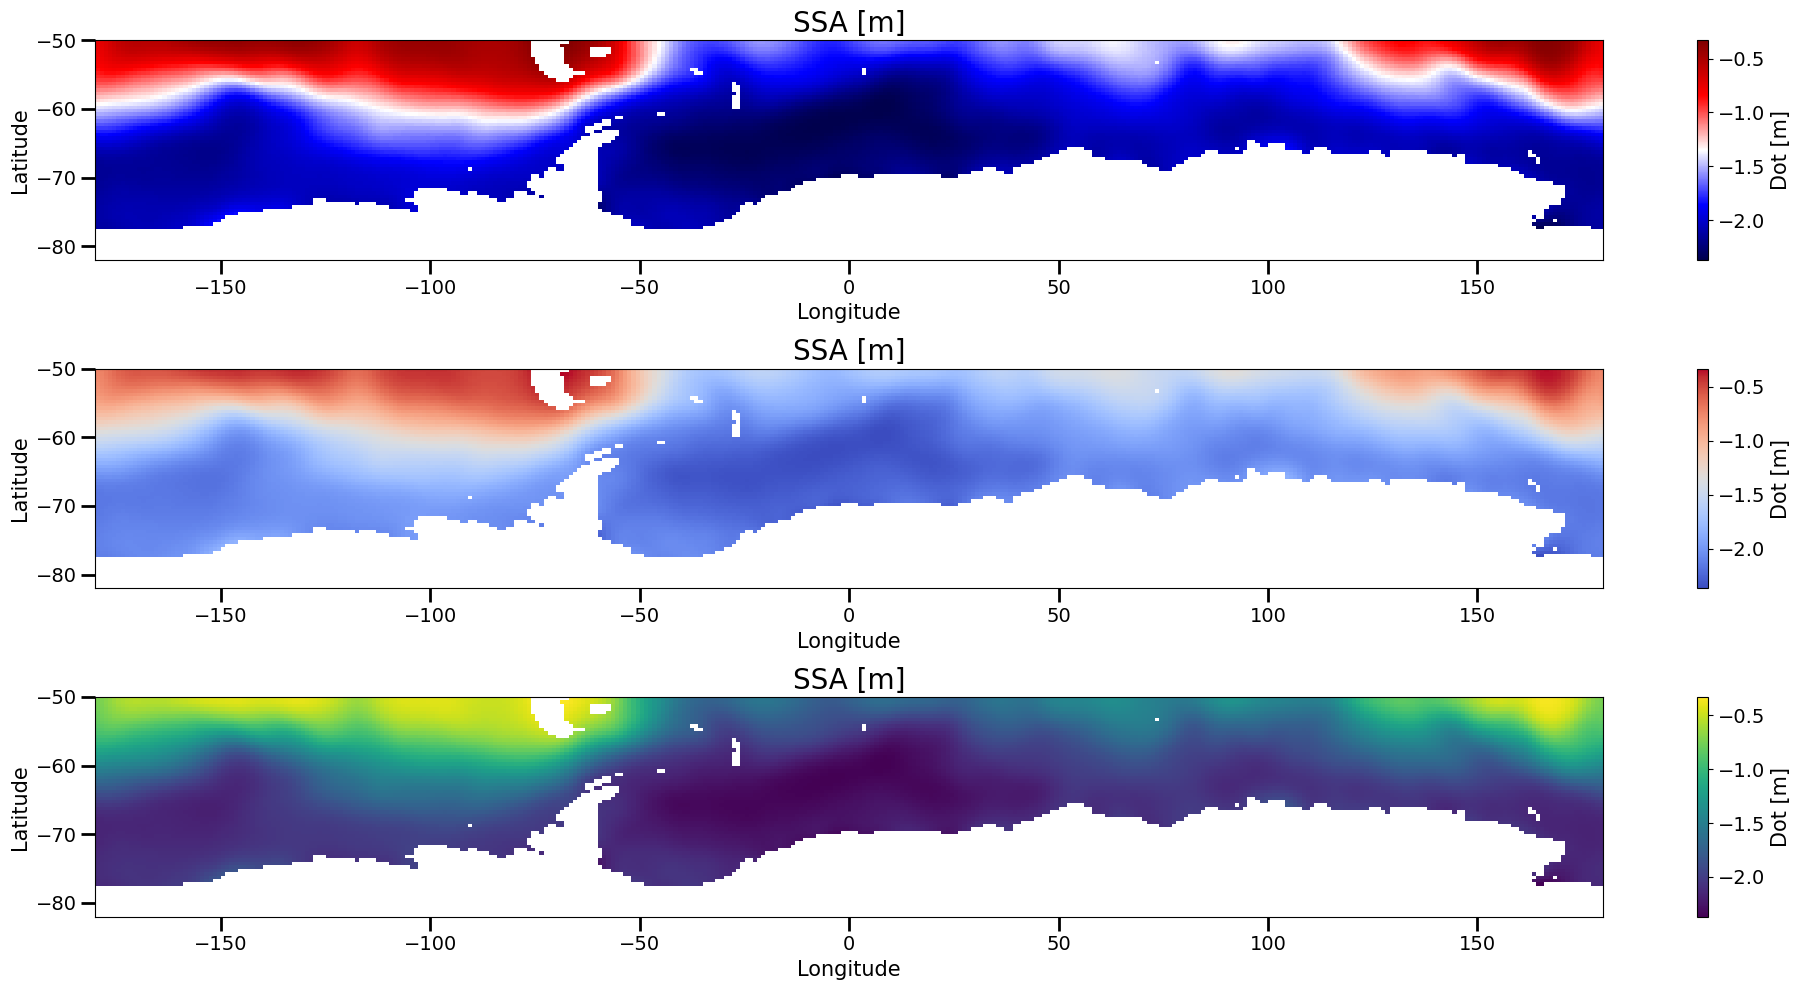

In [77]:
#plot dot with different colour schemes
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 10))

pc1 = axes[0].pcolormesh(llon,llat,dot[0], cmap='seismic')
axes[0].tick_params(axis='both', which='major', length=10, width=2, labelsize=14)
axes[0].set_title('SSA [m]', fontsize=20)
axes[0].set_xlabel('Longitude', fontsize=15)
axes[0].set_ylabel('Latitude', fontsize=15)
cbar1 = fig.colorbar(pc1, ax=axes[0])
cbar1.set_label('Dot [m]', fontsize=15)
cbar1.ax.tick_params(labelsize=14)

pc2 = axes[1].pcolormesh(llon,llat,dot[0], cmap='coolwarm')
axes[1].tick_params(axis='both', which='major', length=10, width=2, labelsize=14)
axes[1].set_title('SSA [m]', fontsize=20)
axes[1].set_xlabel('Longitude', fontsize=15)
axes[1].set_ylabel('Latitude', fontsize=15)
cbar2 = fig.colorbar(pc2, ax=axes[1])
cbar2.set_label('Dot [m]', fontsize=15)
cbar2.ax.tick_params(labelsize=14)

pc3 = axes[2].pcolormesh(llon,llat,dot[0], cmap='viridis')
axes[2].tick_params(axis='both', which='major', length=10, width=2, labelsize=14)
axes[2].set_title('SSA [m]', fontsize=20)
axes[2].set_xlabel('Longitude', fontsize=15)
axes[2].set_ylabel('Latitude', fontsize=15)
cbar3 = fig.colorbar(pc3, ax=axes[2])
cbar3.set_label('Dot [m]', fontsize=15)
cbar3.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

In [78]:
# ds_eumetsat_conc = xr.open_dataset("sic_eumetsat_3D.nc")

In [79]:
# time
time_era5 = ds_era5['time'].values
time_dot = ds['time'].values
time_eumetsat = ds_eumetsat_conc['time'].values

In [80]:
time_dot_array = np.array(time_dot, dtype='datetime64[ns]')
time_eumetsat_array = np.array(time_eumetsat, dtype='datetime64[ns]')

indices_dot_eumetsat = np.where(np.isin(time_eumetsat_array, time_dot_array))
print(indices_dot_eumetsat)

(array([], dtype=int64),)


In [81]:
#make time_eumetsat only have data for the first day of each moth
datetime_array_daily = ds_eumetsat_conc['time']

# Convert the time coordinate to pandas DatetimeIndex
time_index = pd.to_datetime(datetime_array_daily.values)

# List to store the first date of each month
first_dates = []
new_month = []

# Initialize the previous month to None
prev_month = None

# Iterate through the datetime array
for current_date in time_index:
    if current_date.month != prev_month:
        #first date in each month
        new_month.append(current_date)
        # Add the date to the list when the month changes
        first_of_month = current_date.replace(day=1,hour=0, minute=0, second=0, microsecond=0)
        first_dates.append(first_of_month)
        # Update the previous month
        prev_month = current_date.month

# Convert the list to a pandas Series or numpy array (optional)
first_dates_array = pd.Series(first_dates)

# Convert to ISO 8601 format with nanoseconds and "T" separator
first_dates_array_formatted = first_dates_array.dt.strftime('%Y-%m-%dT%H:%M:%S.%f000')



#select the u and v for when the month changes
new_month_mask = time_index.isin(new_month)
subset_ds = ds_eumetsat_conc.sel(time=new_month_mask)
subset_ds = subset_ds.assign_coords(time=first_dates_array_formatted)

print("Original subset time shape:", subset_ds['time'].shape)
print("Formatted dates shape:", first_dates_array_formatted.shape)



# Print the results
print("First dates of each month:")
print(first_dates_array_formatted)

print('subset ds:', subset_ds)

Original subset time shape: (162,)
Formatted dates shape: (162,)
First dates of each month:
0      2002-07-01T00:00:00.000000000
1      2002-08-01T00:00:00.000000000
2      2002-09-01T00:00:00.000000000
3      2002-10-01T00:00:00.000000000
4      2002-11-01T00:00:00.000000000
                   ...              
157    2015-08-01T00:00:00.000000000
158    2015-09-01T00:00:00.000000000
159    2015-10-01T00:00:00.000000000
160    2015-11-01T00:00:00.000000000
161    2015-12-01T00:00:00.000000000
Length: 162, dtype: object
subset ds: <xarray.Dataset> Size: 1GB
Dimensions:                   (time: 162, nv: 2, yc: 432, xc: 432)
Coordinates:
  * xc                        (xc) float64 3kB -5.388e+03 ... 5.388e+03
  * yc                        (yc) float64 3kB 5.388e+03 ... -5.388e+03
    lat                       (yc, xc) float32 746kB -16.62 -16.82 ... -16.62
    lon                       (yc, xc) float32 746kB -45.0 -44.87 ... 135.0
  * time                      (time) object 1kB '2002-07-0

In [82]:
time_dot_array = np.array(time_dot, dtype='datetime64[ns]')
time_eumetsat_array = np.array(subset_ds['time'], dtype='datetime64[ns]')

indices_dot_eumetsat = np.where(np.isin(time_eumetsat_array, time_dot_array))
print(indices_dot_eumetsat)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161]),)


In [83]:
indices_era_eumetsat = np.where(np.isin(time_era5, time_eumetsat_array))
print(indices_era_eumetsat)

(array([ 30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 188, 189, 190, 191]),)


In [84]:
#print(time_era5)
print("dot time", time_dot[0],time_dot[161])
print("era5 time", time_era5[30],time_era5[191])
print("eumetsat conc time", time_eumetsat[0],time_eumetsat[-1])

print('length of time eumetsat array:' , len(time_eumetsat))

dot time 2002-07-01T00:00:00.000000000 2015-12-01T00:00:00.000000000
era5 time 2002-07-01T00:00:00.000000000 2015-12-01T00:00:00.000000000
eumetsat conc time 2002-07-03T12:00:00.000000000 2015-12-31T12:00:00.000000000
length of time eumetsat array: 3149


In [85]:
tstart_dot = 0
tend_dot = 162

tstart_era5 = 30
tend_era5 = 192 # +1 respect cell above

tstart_eumetsat = 0
tend_eumetsat = 162 #+1 respect cell above

In [86]:
# select sea ice concentration
seaice_concentration = subset_ds['ice_conc'][tstart_eumetsat:tend_eumetsat].values
print(seaice_concentration.shape)
print(np.nanmax(seaice_concentration))

(162, 432, 432)
100.0


(162, 432, 432)
100.0
(162,)
(162,)


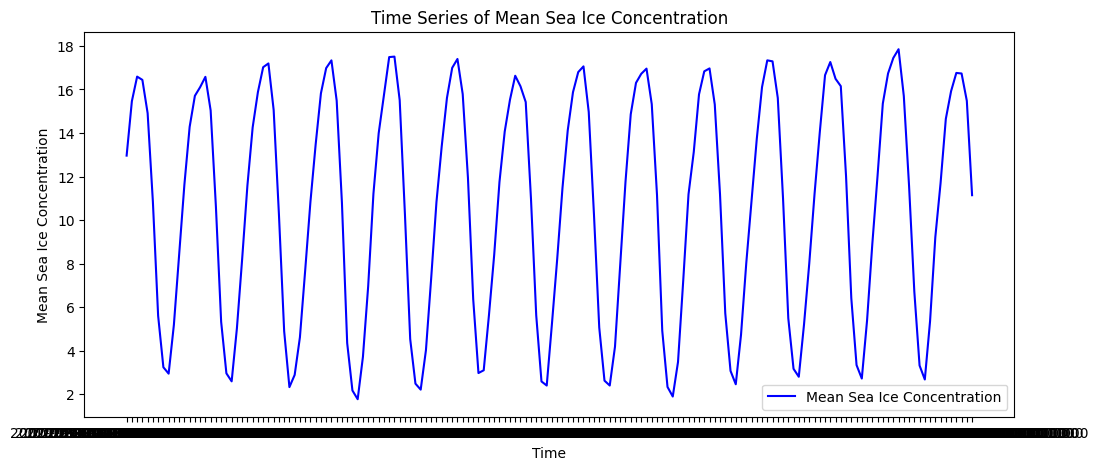

In [87]:
import matplotlib.pyplot as plt

# Assuming the time range tstart_eumetsat and tend_eumetsat are defined
# Extract sea ice concentration over the desired time range
seaice_concentration = subset_ds['ice_conc'][tstart_eumetsat:tend_eumetsat].values

# Check the shape of seaice_concentration to ensure it's (time_steps, yc, xc)
print(seaice_concentration.shape)
print(np.nanmax(seaice_concentration))

# Extract time values (assuming the time is in datetime format)
time_range = subset_ds['time'][tstart_eumetsat:tend_eumetsat].values

# Check the shape of time_range to confirm it's 1D (time_steps,)
print(time_range.shape)

# Compute the mean sea ice concentration across all latitudes and longitudes for each time step
mean_seaice_conc = np.nanmean(seaice_concentration, axis=(1, 2))  # Mean across (yc, xc)

# Check the shape of the mean sea ice concentration to confirm it's 1D
print(mean_seaice_conc.shape)

# Plot the time series of mean sea ice concentration
plt.figure(figsize=(12, 5))
plt.plot(time_range, mean_seaice_conc, label="Mean Sea Ice Concentration", color='b')

# Formatting the plot
plt.xlabel("Time")
plt.ylabel("Mean Sea Ice Concentration")
plt.title("Time Series of Mean Sea Ice Concentration")
plt.legend()
#plt.grid(True)
#plt.xticks(rotation=45)  # Rotate time labels for better readability
plt.show()


In [88]:
import numpy as np
print(np.nanmax(seaice_concentration))  # Ignores NaN values


100.0


In [89]:
# Check for NaN values in the original data
print(subset_ds['ice_conc'].isnull().sum())  # Number of NaN values in the dataset


<xarray.DataArray 'ice_conc' ()> Size: 8B
array(5389902)
Attributes:
    long_name:            fully filtered concentration of sea ice using atmos...
    standard_name:        sea_ice_area_fraction
    units:                %
    valid_min:            0
    valid_max:            10000
    grid_mapping:         Lambert_Azimuthal_Grid
    ancillary_variables:  total_standard_error status_flag
    comment:              this field is the primary sea ice concentration est...


In [90]:
# DE-TREND DOT
dot = dot[tstart_dot:tend_dot]


In [91]:
# linear regression in time on each grid point
n,slope,intercept,p_val,r_square,rmse = linregress_3D(dot)
# remove trend for dot
xt = np.zeros(dot.shape)
for t in range(0,dot.shape[0]):
    xt[t] = t
dot_detrended = dot - (slope*xt + intercept)

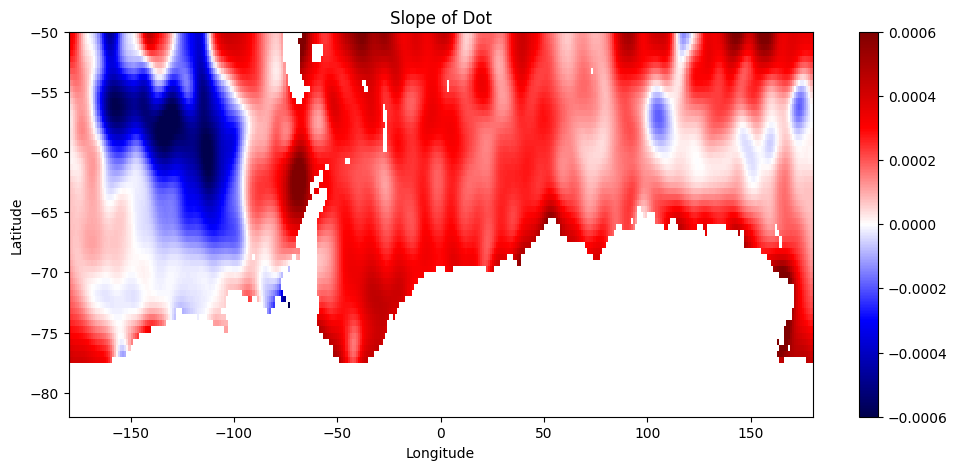

In [92]:
plt.figure(figsize=(12,5))
plt.pcolormesh(llon, llat, slope, vmin=-6e-4, vmax=6e-4, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Slope of Dot')
plt.colorbar()


In [93]:
dot_final = dot_detrended.copy()

In [94]:
seaice_concentration = subset_ds['ice_conc'][tstart_eumetsat:tend_eumetsat].values
print(seaice_concentration.shape)

# Assuming 'time_new' is the time coordinate in the dataset
time_values = ds_eumetsat_conc['time'][tstart_eumetsat:tend_eumetsat].values
print(time_values.shape)  # To verify the shape


(162, 432, 432)
(162,)


In [95]:
t = len(time_values)-1
print(seaice_concentration.shape)
print((seaice_concentration).shape[0])
print((seaice_concentration[t, 0]).shape)


(162, 432, 432)
162
(432,)


In [96]:
#remap data onto dot grid
# Target grid
lon_target = ds['longitude'].values  # (360,)
lat_target = ds['latitude'].values  # (64,)

# Create an empty list to store regridded data
regridded_data_list = []
time_steps_list = []


# Loop through each time step of the original sea ice data
for t in range(seaice_concentration.shape[0]):  # Loop over the time dimension
    # Extracting the sea ice concentration at time t, shape (332, 316)
    seaice = seaice_concentration[t] #changeed this from 0 to t

    # Coordinates for the original grid
    lon_seaice = lon_eumetsat  # (332, 316)
    lat_seaice = lat_eumetsat  # (332, 316)

    # Flatten original grid and sea ice data
    points = np.array([lon_seaice.flatten(), lat_seaice.flatten()]).T  # [lon, lat]
    #print(points.shape)
    values = seaice.flatten()
    #print(values.shape)

    # print(points.shape)
    # print(values.shape)


    # Generate target grid (meshgrid for lon and lat)
    lon_mesh, lat_mesh = np.meshgrid(lon_target, lat_target)  # 2D target grid

    # Interpolate onto the target grid
    seaice_regridded = griddata(points, values, (lon_mesh, lat_mesh), method='linear')

    # Add regridded data to list (append 2D array for this time step)
    regridded_data_list.append(seaice_regridded)

    # Store the corresponding time value
    time_steps_list.append(time_values[t])  # Add the corresponding time step

# Stack the regridded data along the time dimension
regridded_seaice_conc = np.stack(regridded_data_list, axis=0)  # Shape: (time, lat, lon)

# Now you can use regridded_data, and time_steps_list to refer to the time dimension
print(f"Regridded data shape: {regridded_seaice_conc.shape}")
#print(f"Time steps: {time_steps_list}")


Regridded data shape: (162, 64, 360)


In [97]:
# Create a new xarray DataArray with regridded data
regridded_seaice_da = xr.DataArray(
    regridded_seaice_conc,
    dims=("time", "lat", "lon"),
    coords={
        "time": time_steps_list,  # Assuming time steps are just integers
        "lat": lat_target,  # New latitude grid (64,)
        "lon": lon_target,  # New longitude grid (360,)
    },
    name="seaice_concentration",  # Variable name
)

# Create a Dataset with the regridded DataArray
regridded_seaice_ds = xr.Dataset(
    {"seaice_concentration": regridded_seaice_da}
)

# Print dataset to verify
print(regridded_seaice_ds)


<xarray.Dataset> Size: 30MB
Dimensions:               (time: 162, lat: 64, lon: 360)
Coordinates:
  * time                  (time) datetime64[ns] 1kB 2002-07-03T12:00:00 ... 2...
  * lat                   (lat) float64 512B -81.75 -81.25 ... -50.75 -50.25
  * lon                   (lon) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
Data variables:
    seaice_concentration  (time, lat, lon) float64 30MB nan nan nan ... 0.0 0.0


<xarray.Dataset> Size: 30MB
Dimensions:               (time: 162, lat: 64, lon: 360)
Coordinates:
  * time                  (time) datetime64[ns] 1kB 2002-07-03T12:00:00 ... 2...
  * lat                   (lat) float64 512B -81.75 -81.25 ... -50.75 -50.25
  * lon                   (lon) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
Data variables:
    seaice_concentration  (time, lat, lon) float64 30MB nan nan nan ... 0.0 0.0


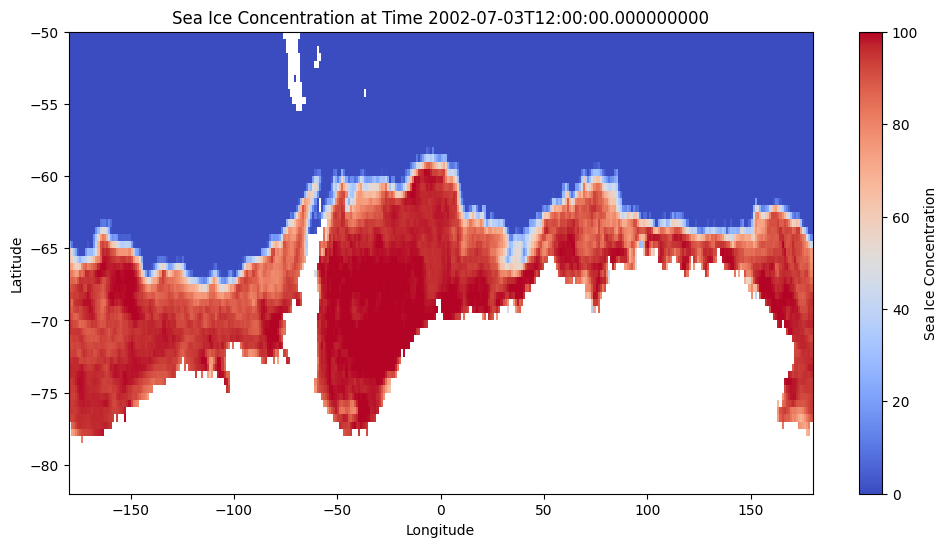

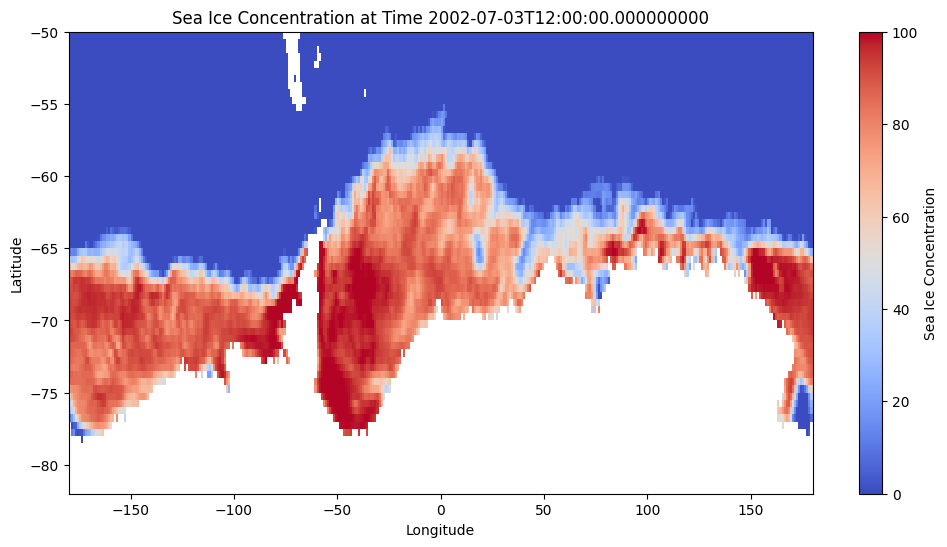

In [98]:
print(regridded_seaice_ds)

# Extract the time, latitude, and longitude coordinates
time_values = regridded_seaice_ds['time'].values
lat_values = regridded_seaice_ds['lat'].values
lon_values = regridded_seaice_ds['lon'].values

# Create a meshgrid for lat/lon coordinates for plotting
lon_mesh, lat_mesh = np.meshgrid(lon_values, lat_values)

# Plot the sea ice concentration at time step 0 (can change the time index)
plt.figure(figsize=(12, 6))
plt.pcolormesh(llon, llat, regridded_seaice_conc[0], cmap='coolwarm', shading='auto')
plt.colorbar(label='Sea Ice Concentration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Sea Ice Concentration at Time {time_values[0]}')  # Use time label for title
plt.show()

# Plot the sea ice concentration at time step 0 (can change the time index)
plt.figure(figsize=(12, 6))
plt.pcolormesh(llon, llat, regridded_seaice_conc[-1], cmap='coolwarm', shading='auto')
plt.colorbar(label='Sea Ice Concentration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Sea Ice Concentration at Time {time_values[0]}')  # Use time label for title
plt.show()

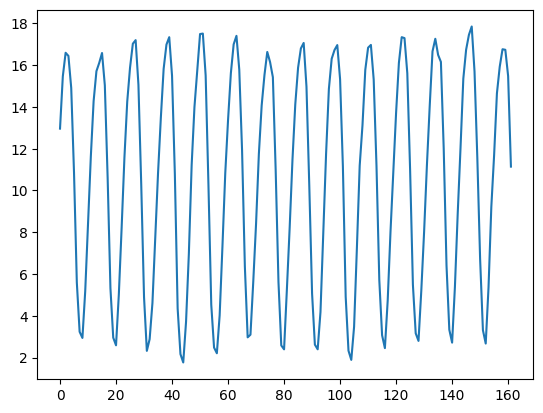

In [99]:
plt.plot(np.nanmean(subset_ds['ice_conc'], axis=(1,2)))

In [100]:

# # Mask values > 1
# regridded_seaice_filtered = np.where(regridded_seaice_conc >1,  np.nan, regridded_seaice_conc)
#
# # Verify the masking
# print("Original max value in regridded:", np.nanmax(regridded_seaice_conc))
# print("Max value after masking in regridded_seaice_masked:", np.nanmax(regridded_seaice_filtered))
#
# # Plot the sea ice concentration at time step 0 (you can change the time index)
# plt.figure(figsize=(12, 6))
# plt.pcolormesh(llon, llat, regridded_seaice_filtered[0], cmap='coolwarm', shading='auto')
# plt.colorbar(label='Sea Ice Concentration')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.title(f'Sea Ice Concentration at Time {time_values[0]}')  # Use time label for title
# plt.show()


In [101]:
icemask = regridded_seaice_conc[0].copy()/regridded_seaice_conc[0]
icemask[icemask == 0] = np.nan

In [102]:
#apply the icemask

# Apply the mask to the entire seaice_detrended dataset
seaice_masked = regridded_seaice_conc * icemask[np.newaxis, :, :]

In [103]:
# #detrend seaice conc - not using the masked seaice
# #KEEP THIS CELL BUT COMMENT OR UNCOMMENT THIS/CELL BELOW TO USE SEAICE_MASKED OR NOT ...
# # linear regression in time on each grid point
# n_si,slope_si,intercept_si,p_val_si,r_square_si,rmse_si = linregress_3D(regridded_seaice_filtered)
# # remove trend for dot
# xt_si = np.zeros(regridded_seaice_filtered.shape)
# for t in range(0,regridded_seaice_filtered.shape[0]):
#     xt_si[t] = t
# seaice_detrended = regridded_seaice_filtered - (slope_si*xt_si + intercept_si)
# slope_si = slope_si.squeeze()
#
# # Verify shapes
# print("Longitude shape:", lon_mesh.shape)
# print("Latitude shape:", lat_mesh.shape)
# print("Data shape (slope_si):", slope_si.shape)


In [104]:
#detrend seaice conc - using seaice_masked
# linear regression in time on each grid point
n_si,slope_si,intercept_si,p_val_si,r_square_si,rmse_si = linregress_3D(seaice_masked)
# remove trend for dot
xt_si = np.zeros(seaice_masked.shape)
for t in range(0,seaice_masked.shape[0]):
    xt_si[t] = t
seaice_detrended = seaice_masked - (slope_si*xt_si + intercept_si)
slope_si = slope_si.squeeze()

# Verify shapes
print("Longitude shape:", lon_mesh.shape)
print("Latitude shape:", lat_mesh.shape)
print("Data shape (slope_si):", slope_si.shape)

Longitude shape: (64, 360)
Latitude shape: (64, 360)
Data shape (slope_si): (64, 360)


In [105]:
print('slope range: ', slope_si.min(), slope_si.max(), slope_si.mean(), slope_si.std())

print('seaice conc range:', regridded_seaice_conc.min(), regridded_seaice_conc.max())
print("Number of NaN values in slope_si:", np.isnan(slope_si).sum())


slope range:  nan nan nan nan
seaice conc range: nan nan
Number of NaN values in slope_si: 16864


In [106]:
seaice_final = seaice_detrended.copy()

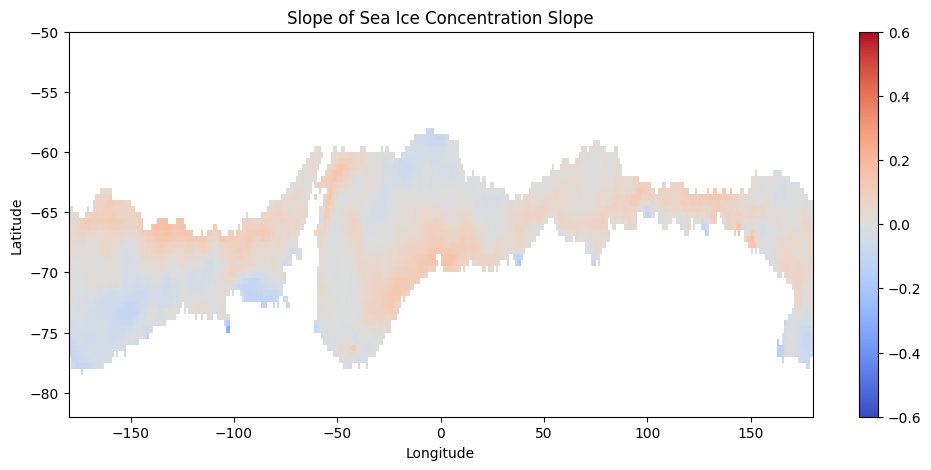

In [107]:
plt.figure(figsize=(12,5))
plt.pcolormesh(llon, llat, slope_si, vmin=-6e-1, vmax=6e-1, cmap='coolwarm')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Slope of Sea Ice Concentration Slope')
plt.colorbar()

In [108]:
#DESEASONAL
time_dot = time_dot[tstart_dot:tend_dot]

In [109]:
#deseasonal for sea ice and dot
months = time_dot.astype('datetime64[M]').astype(int) % 12 + 1
print(months.shape)

(162,)


In [110]:
# find and remove seasonality from dot_detrended and seaice_detrended
dot_seas = np.zeros((12,dot.shape[1],dot.shape[2])); seaice_seas = np.zeros((12,dot.shape[1],dot.shape[2]))
for m in range(1,13):
    dot_seas[m-1] = np.nanmean(dot_detrended[np.where(months==m)], axis=0)
    seaice_seas[m-1] = np.nanmean(seaice_detrended[np.where(months==m)], axis=0)

# remove seasonality from dot and sea ice concetration
dot_final = np.zeros(dot_detrended.shape); seaice_final = np.zeros(seaice_detrended.shape)
for i,m in enumerate(months):
    dot_final[i] = dot_detrended[i] - dot_seas[m-1]
    seaice_final[i] = seaice_detrended[i] - seaice_seas[m-1]

In [111]:
print("dot shape:", time_dot.shape)
print("time_eumetsat_array length:", len(time_eumetsat_array))


dot shape: (162,)
time_eumetsat_array length: 162


In [112]:
print(np.unique(months))
dot_seas = np.zeros((12, dot.shape[1], dot.shape[2]))
seaice_seas = np.zeros((12, dot.shape[1], dot.shape[2]))  # Should match seaice_detrended



[ 1  2  3  4  5  6  7  8  9 10 11 12]


In [113]:
print("dot_detrended shape:", dot_detrended.shape)
print("seaice_detrended shape:", seaice_detrended.shape)
print("months shape:", months.shape)


dot_detrended shape: (162, 64, 360)
seaice_detrended shape: (162, 64, 360)
months shape: (162,)


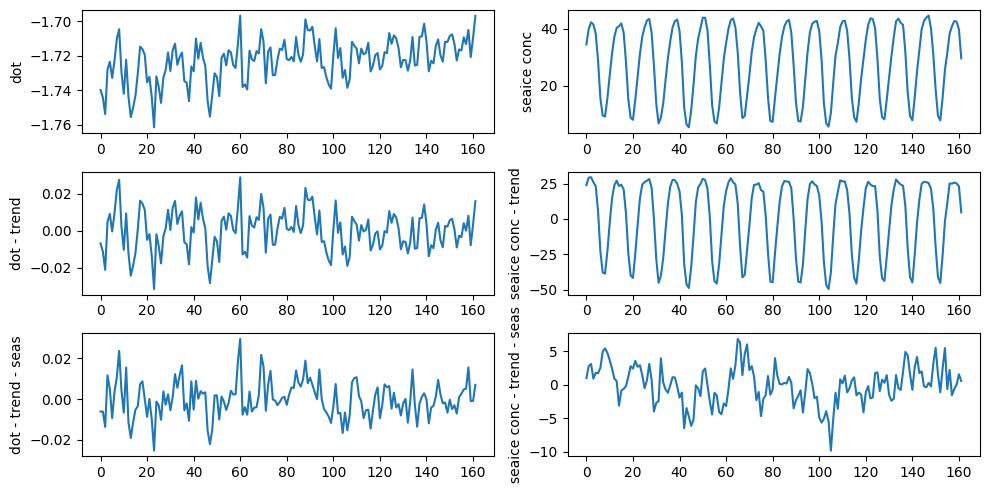

In [114]:
fig = plt.figure(figsize=(10,5))
plt.subplot(3,2,1)
plt.plot(np.nanmean(dot, axis=(1,2)))
plt.ylabel('dot')
plt.subplot(3,2,2)
plt.plot(np.nanmean(regridded_seaice_conc, axis=(1,2)))
plt.ylabel('seaice conc')
plt.subplot(3,2,3)
plt.plot(np.nanmean(dot_detrended, axis=(1,2)))
plt.ylabel('dot - trend')
plt.subplot(3,2,4)
plt.plot(np.nanmean(seaice_detrended, axis=(1,2)))
plt.ylabel('seaice conc - trend')
plt.subplot(3,2,5)
plt.plot(np.nanmean(dot_final, axis=(1,2)))
plt.ylabel('dot - trend - seas')
plt.subplot(3,2,6)
plt.plot(np.nanmean(seaice_final, axis=(1,2)))
plt.ylabel('seaice conc - trend - seas')

plt.tight_layout()

In [115]:
print(time_eumetsat_array[90])

2010-01-01T00:00:00.000000000


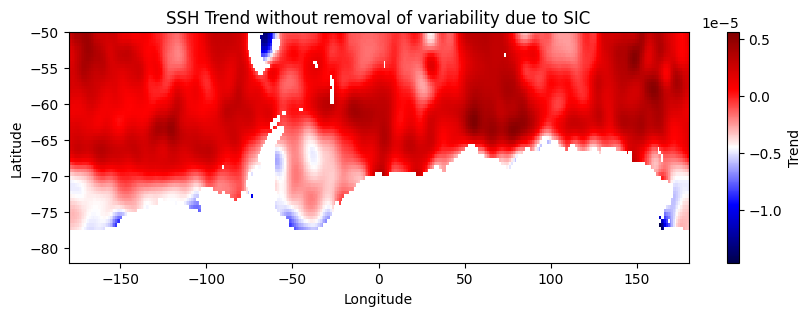

In [116]:
# SSH trends without removing ocean variability due to sea ice concentration
plt.figure(figsize=(10,3))
n,slope,intercept,p_val,r_square,rmse = linregress_3D(dot_final)
plt.pcolormesh(lon_mesh, lat_mesh, slope, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('SSH Trend without removal of variability due to SIC')
cbar = plt.colorbar()
cbar.set_label('Trend')

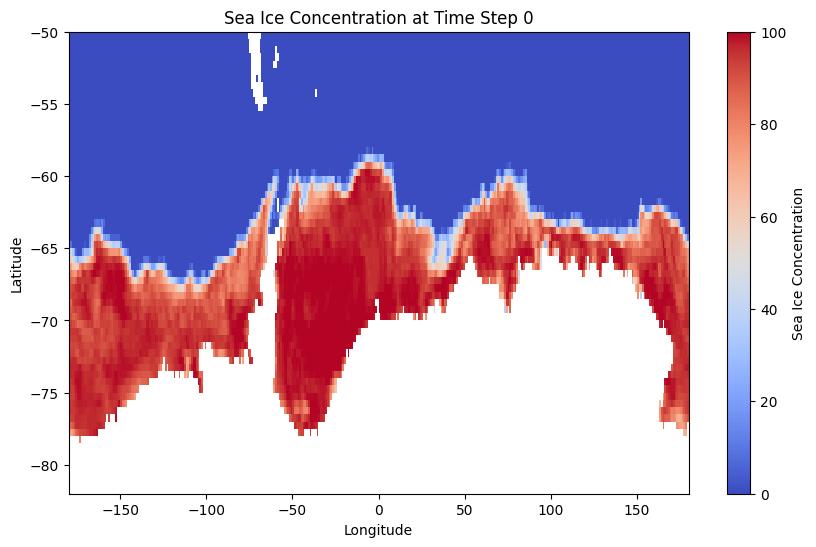

In [117]:
time_step = 0  # You can change this to any index from 0 to 195 (since the shape is (196, 64, 360))

# Extract and plot the masked data for the selected time step
seaice_at_t = regridded_seaice_conc[time_step]


# Plot the data using pcolormesh
plt.figure(figsize=(10, 6))
plt.pcolormesh( lon_mesh, lat_mesh,seaice_at_t, cmap='coolwarm', shading='auto')
plt.colorbar(label='Sea Ice Concentration')
plt.title(f"Sea Ice Concentration at Time Step {time_step}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [118]:
# MCA

In [119]:
dot_xa = xr.DataArray(dot_final, coords=[time_dot, lat_values, lon_values], dims=["time", "lon", "lat"],)
seaice_xa = xr.DataArray(seaice_final, coords=[time_dot, lat_values, lon_values], dims=["time", "lon", "lat"],)



# print(dot_xa.values)
# print('/n---/n')
# print(seaice_xa.values)

min_value = seaice_xa.where(~seaice_xa.isnull()).min().item()
max_value = seaice_xa.where(~seaice_xa.isnull()).max().item()
print(f"Range of values (excluding NaN): Min = {min_value}, Max = {max_value}")


Range of values (excluding NaN): Min = -89.66210348855681, Max = 88.9665889816168


In [120]:
total_nans = dot_xa.isnull().sum().item()
print(f"Total NaN values in dot_xa: {total_nans}")

total_nans_seaice = seaice_xa.isnull().sum().item()
print(f"Total NaN values in seaice_xa: {total_nans_seaice}")

total_points_dot = dot_xa.size
print(f"Total data points in dot_xa: {total_points_dot}")

total_points_seaice = seaice_xa.size
print(f"Total data points in seaice_xa: {total_points_seaice}")

print(seaice_xa.shape)
print(dot_xa.shape)



Total NaN values in dot_xa: 1307826
Total NaN values in seaice_xa: 2731968
Total data points in dot_xa: 3732480
Total data points in seaice_xa: 3732480
(162, 64, 360)
(162, 64, 360)


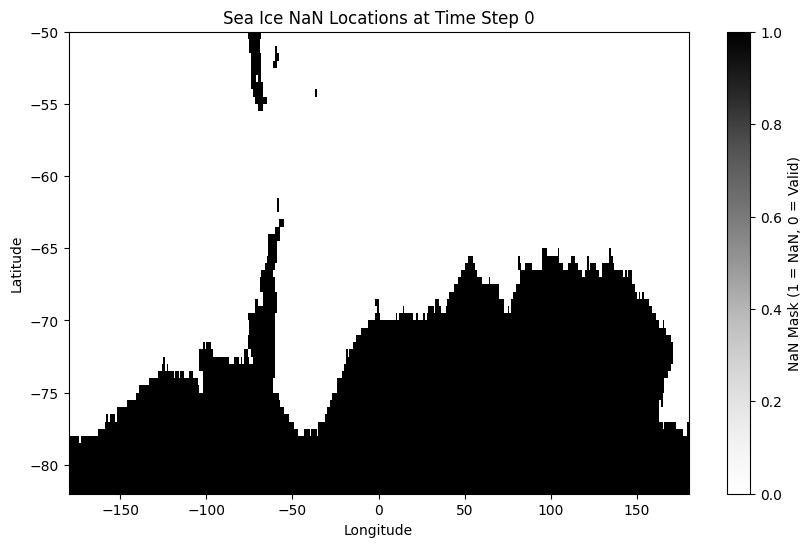

In [121]:
#plot where there are nan values (this is where i created the mask for SIC > 1 earlier)
time_step = 0
# Create a mask where NaN values are True
seaice_nan_mask = np.isnan(regridded_seaice_conc[time_step])

# Plot the mask using pcolormesh
plt.figure(figsize=(10, 6))
plt.pcolormesh(
    lon_mesh, lat_mesh, seaice_nan_mask,
    cmap='Greys', shading='auto'
)
plt.colorbar(label='NaN Mask (1 = NaN, 0 = Valid)')
plt.title(f"Sea Ice NaN Locations at Time Step {time_step}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [122]:

print(dir(xe))

['RotatorFactory', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_version', 'base_model', 'cross', 'data_container', 'linalg', 'multi', 'preprocessing', 'rotator_factory', 'single', 'utils', 'validation']


In [123]:
#set all NaN values to = 0 in dot and seaice. this means there has been no change
dot_xa_masked = dot_xa.fillna(0)
seaice_xa_masked = seaice_xa.fillna(0)

print("Masked dot_xa shape:", dot_xa_masked.shape)
print("Masked seaice_xa shape:", seaice_xa_masked.shape)

Masked dot_xa shape: (162, 64, 360)
Masked seaice_xa shape: (162, 64, 360)


In [124]:
print("Remaining NaNs in dot_xa_masked:", dot_xa_masked.isnull().sum().item())
print("Remaining NaNs in seaice_xa_masked:", seaice_xa_masked.isnull().sum().item())


Remaining NaNs in dot_xa_masked: 0
Remaining NaNs in seaice_xa_masked: 0


In [125]:
print(seaice_xa_masked.shape)

(162, 64, 360)


In [126]:
# #create nc file from seaice_xa_masked ds
#
# # Create a new xarray DataArray with the seaice_xa_masked data
# seaice_xa_masked_da = xr.DataArray(
#     seaice_xa_masked,  # Use your masked sea ice data here
#     dims=("time", "lat", "lon"),  # Define the dimensions
#     coords={
#         "time": time_steps_list,  # Replace with your actual time steps
#         "lat": lat_target,  # Latitude coordinate (e.g., (64,))
#         "lon": lon_target,  # Longitude coordinate (e.g., (360,))
#     },
#     name="seaice_xa_masked",  # Give the variable a name
# )
#
# # Create a Dataset with the seaice_xa_masked DataArray
# seaice_xa_masked_ds = xr.Dataset(
#     {"seaice_xa_masked": seaice_xa_masked_da}
# )
#
# # Print dataset to verify its structure
# print(seaice_xa_masked_ds)
#
# # Save the dataset to a NetCDF file
# output_file = "seaice_xa_masked_nsdic.nc"
# seaice_xa_masked_ds.to_netcdf(output_file)
#
# print(f"NetCDF file created: {output_file}")




In [127]:
print(dir(xe))


['RotatorFactory', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_version', 'base_model', 'cross', 'data_container', 'linalg', 'multi', 'preprocessing', 'rotator_factory', 'single', 'utils', 'validation']


In [128]:
import inspect
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(dot_xa_masked.coords)
print(seaice_xa_masked.coords)

model.fit(dot_xa_masked, seaice_xa_masked, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)

Coordinates:
  * time     (time) datetime64[ns] 1kB 2002-07-01 2002-08-01 ... 2015-12-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 1kB 2002-07-01 2002-08-01 ... 2015-12-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5


In [129]:
s1 = scores1.values; s2 = scores2.values
c1 = comps1.values; c2 = comps2.values

In [130]:
print(path)
print(gridtype)

/Users/iw2g24/PycharmProjects/SSH_project/
remapcon


In [131]:
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")

Directory already exists


In [132]:
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_dot_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0,i]}\t{s1[1,i]}\t{s1[2,i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_si_concentration_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0,i]}\t{s2[1,i]}\t{s2[2,i]}\n')
file.close()

In [133]:
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...

In [134]:
r_pears = []; p_pears = []
r_spear = []; p_spear = []
for m in range(1,5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2)); p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2)); p_spear.append(np.round(p, 2))

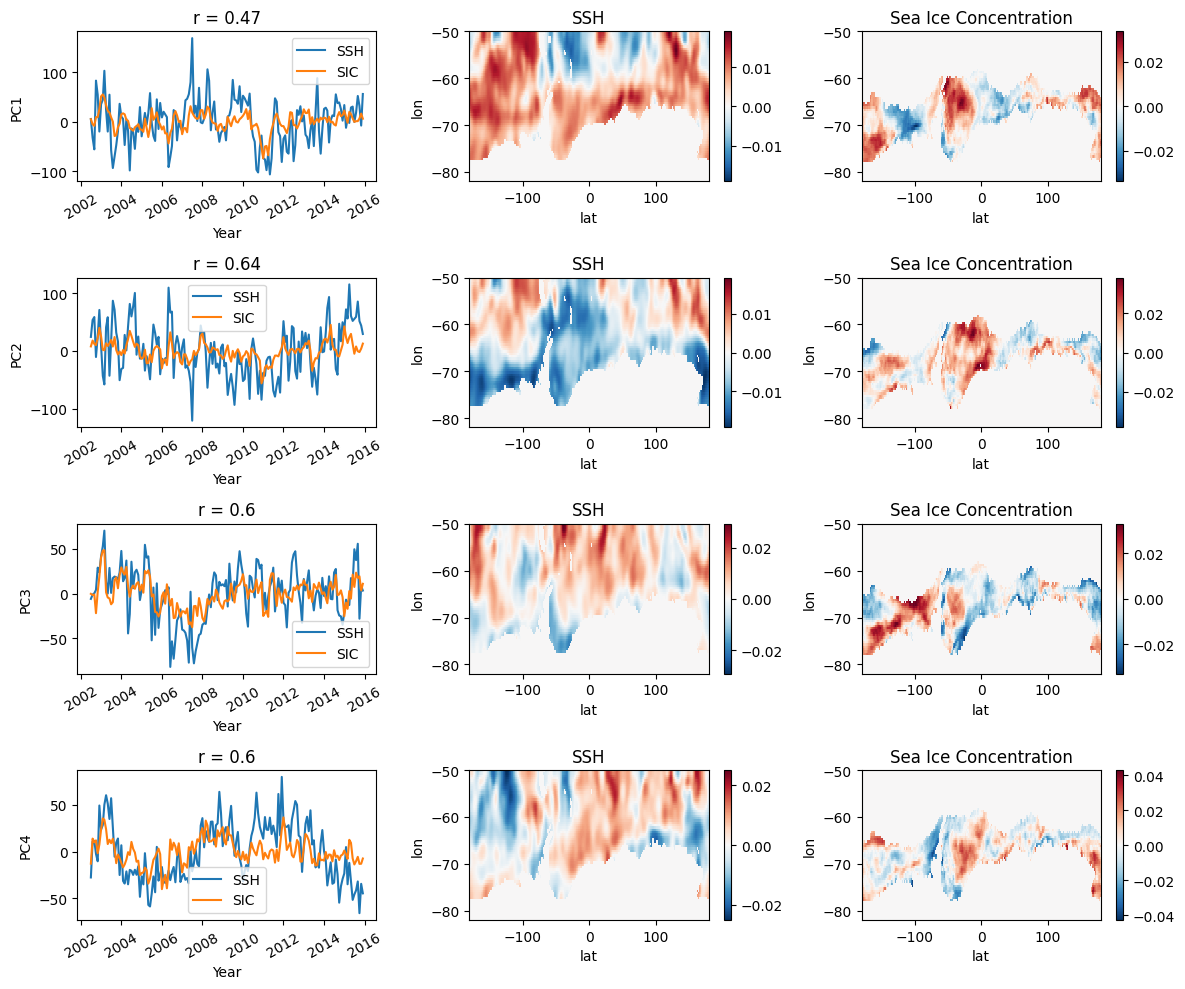

In [135]:
fig = plt.figure(figsize=(12,10))

for i in range(0,4):
    j = 3*i+1 # a = 2*(i+1) + i - 1
    
    plt.subplot(4,3,j)
    scores1.sel(mode=i+1).plot(label = 'SSH')
    scores2.sel(mode=i+1).plot(label = 'SIC')
    plt.title('r = ' +str(r_spear[i]))
    plt.xlabel('Year'); plt.ylabel('PC'+str(int(i+1)))
    plt.xticks(rotation=30) 
    plt.legend()
    
    plt.subplot(4,3,j+1)
    comps1.sel(mode=i+1).plot()
    plt.title('SSH')
    
    plt.subplot(4,3,j+2)
    comps2.sel(mode=i+1).plot()
    plt.title('Sea Ice Concentration')

fig.tight_layout()

#fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')

In [136]:

# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:',scf)

Cumulative sum of squares: [0.2693468  0.50426189 0.61046622 0.69108264 0.74633241 0.78246836
 0.81024314 0.83635482 0.85586273 0.87176146 0.88634014 0.90044404
 0.91331752 0.92415261 0.93401913 0.94139998 0.9486143  0.9547001
 0.95991656 0.96456935 0.96919069 0.97331695]
Squared covariance fraction: [0.2693468  0.23491509 0.10620433 0.08061643 0.05524977 0.03613596
 0.02777478 0.02611168 0.01950791 0.01589872 0.01457868 0.0141039
 0.01287348 0.01083509 0.00986651 0.00738085 0.00721432 0.0060858
 0.00521646 0.00465279 0.00462133 0.00412626]


In [137]:
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent =float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i]-cum_sum[i-1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)


<class 'numpy.ndarray'>
22
PCA fraction [0.2693467991963693, 0.23491509075060535, 0.10620432516148892, 0.08061642509538403, 0.055249766549019474, 0.03613595588507723, 0.027774777805108286, 0.026111679216460515, 0.019507913779813535, 0.01589872248936275, 0.014578683602007203, 0.014103896669359961, 0.012873482797540414, 0.010835092384427925, 0.009866514330358678, 0.007380853005811483, 0.007214324530912197, 0.006085801186333284, 0.005216458833378845, 0.004652791629427999, 0.004621331770749415, 0.004126264544725977]
